# METADATA
- fixation time graph
- task completion time
- subject variation in fixation

In [2]:
import os, csv, pickle, gzip, torch, copy
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.transform import Rotation as R

from tqdm import tqdm
from matplotlib import rc #change xtick & ytick size
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['font.family'] = "Arial"
from scipy.signal import butter, lfilter, freqz


#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z

def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output

#========= read =========================================================================
"""
sfile: sorted params for each subject
ffile: trimmed feature files for all subs
dffile: time metadatafile for all subs
PARAMS: pamareter file for all subs


"""
spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold a and b instead of simple subtraction that is useless
# file_name = "0919-f18r16ver2"
# fpath = "data/data_feature/" + file_name + ".gz"
# ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','target_idx','length', 'orig_length','h','v','d']]
print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])

<bound method NDFrame.head of       sub_idx  file_idx  target_idx  length  orig_length          h  \
0           0         9           0     233          408 -30.000000   
1           0        42           0     168          440 -30.000000   
2           0       118           0     196          377 -30.000000   
3           0       141           0     175          369 -30.000000   
4           0        35           1     229          408 -30.000000   
...       ...       ...         ...     ...          ...        ...   
3451       23        29          34     245          442 -16.339005   
3452       23        91          35     171          373  -3.540169   
3453       23        66          35     191          390  -3.483050   
3454       23        31          35     197          397  18.433158   
3455       23        32          35     185          401  20.653209   

              v         d  
0    -20.000000  0.900000  
1    -20.000000  0.900000  
2    -20.000000  0.900000  
3    

## 1. Visualize Completion Time with (bar chart & distribution graph)
- bar chart is more intuitive
- KD graph can lead to misleading comprehension of data due to density values

C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_21168\2091595278.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_21168\2091595278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'length'] = data.loc[:,'length'] / 120


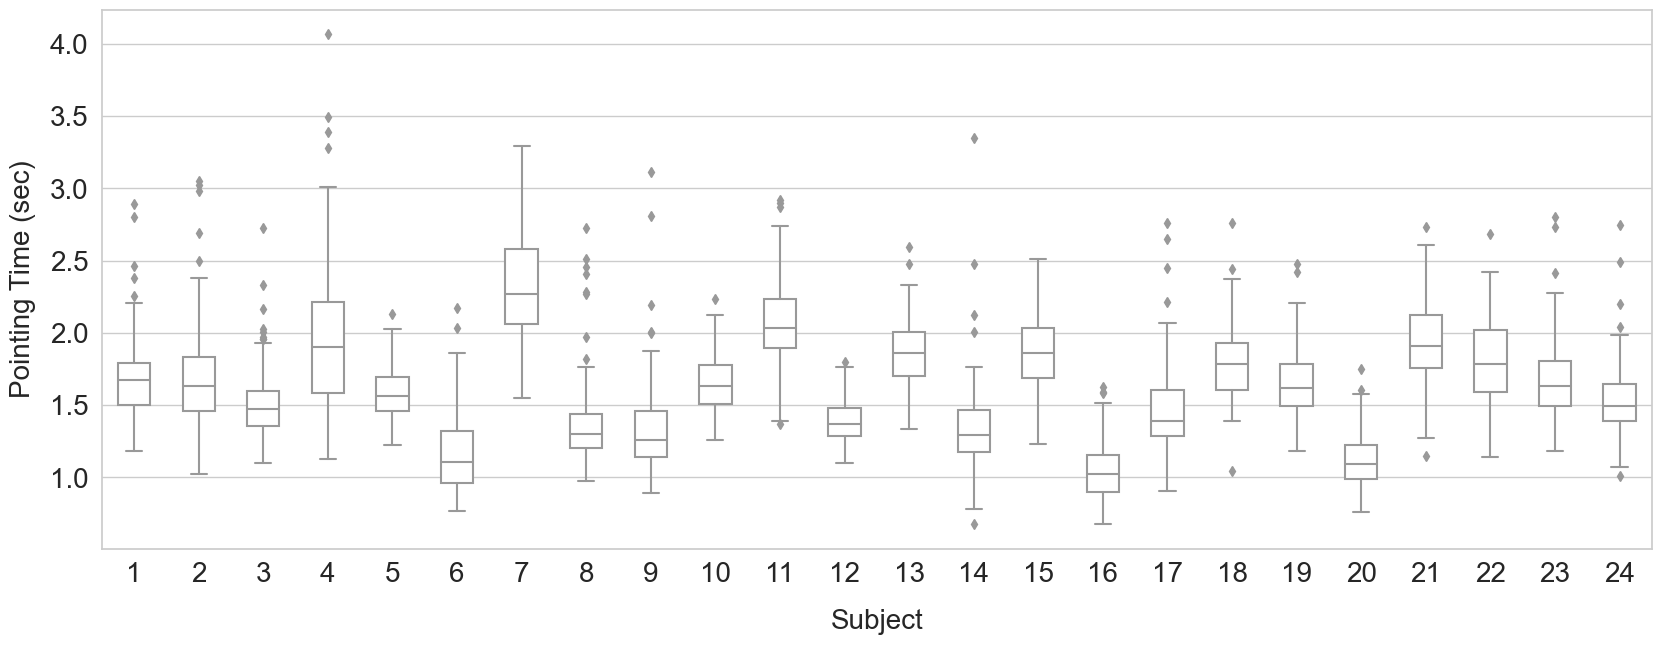

In [3]:
# data1 = file_method_grouping.loc[file_method_grouping['plot'] == 'gesture_distinction']

data = dffile[dffile.length != -1]
data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
data.loc[:,'length'] = data.loc[:,'length'] / 120
fig1 = plt.figure(figsize = (20,7))
sns.set(style="ticks", palette='Set3')
sns.set_style("whitegrid")
plot = sns.boxplot(x='sub_idx', y='length', data=data, color='white', width=0.5)
plot.set_xlabel("Subject",fontsize=20, labelpad=15)
plot.set_ylabel("Pointing Time (sec)",fontsize=20, labelpad=10)
plot.tick_params(labelsize=20)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
# plt.title('completion_time', fontdict = {'fontsize' : 20})

# 2. Visualize Completion Time by target name

C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_21168\2415952299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'target_idx'] = data.loc[:,'target_idx']  +1
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_21168\2415952299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'length'] = data.loc[:,'length'] / 120


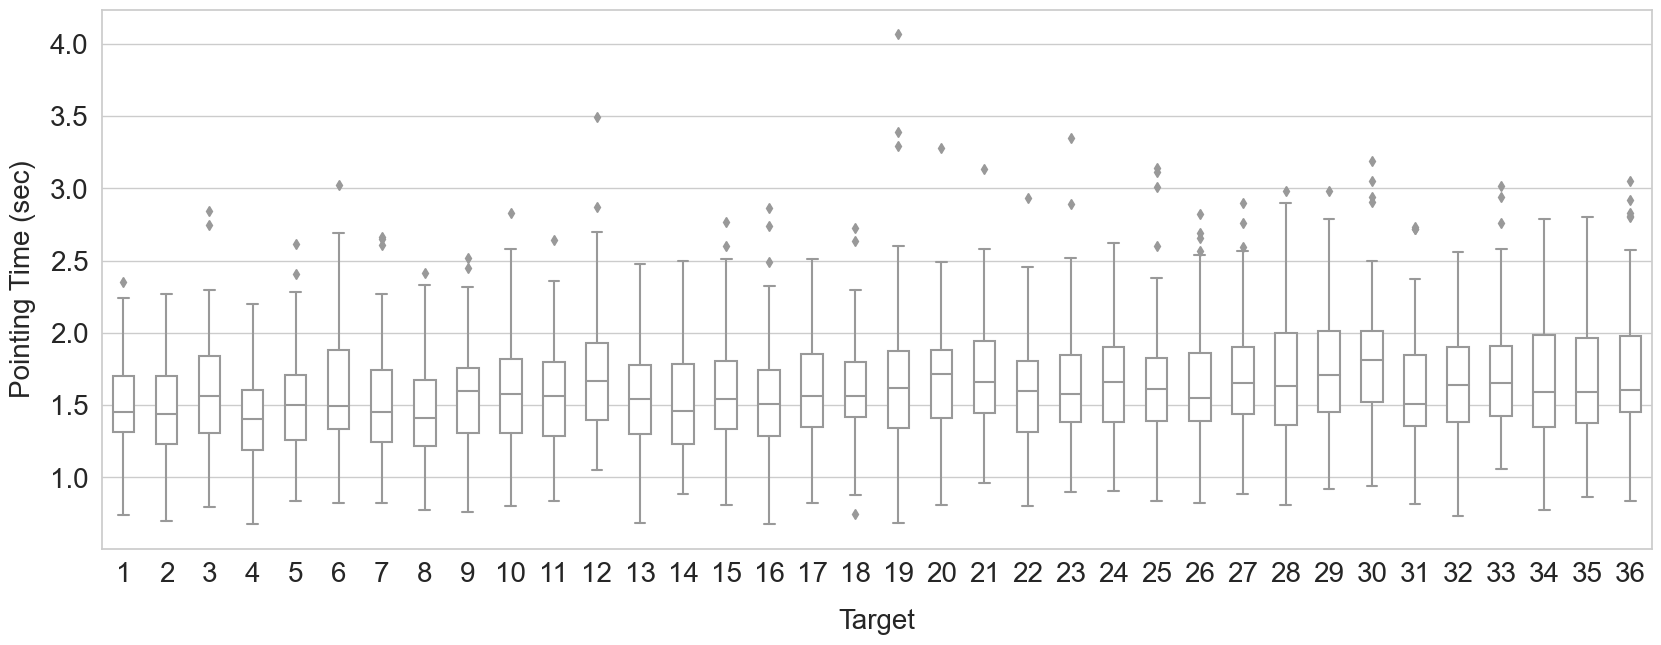

In [6]:
# data1 = file_method_grouping.loc[file_method_grouping['plot'] == 'gesture_distinction']

data = dffile[dffile.length != -1]
data.loc[:,'target_idx'] = data.loc[:,'target_idx']  +1
data.loc[:,'length'] = data.loc[:,'length'] / 120
fig1 = plt.figure(figsize = (20,7))
sns.set(style="ticks", palette='Set3')
sns.set_style("whitegrid")


plot = sns.boxplot(x='target_idx', y='length', data=data, color='white', width=0.5)
plot.set_xlabel("Target",fontsize=20, labelpad=15)
plot.set_ylabel("Pointing Time (sec)",fontsize=20, labelpad=10)
plot.tick_params(labelsize=20)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
# plt.title('completion_time', fontdict = {'fontsize' : 20})

# 3. Completion Time with Distribition - Nor recommended - hard to mistake meaning

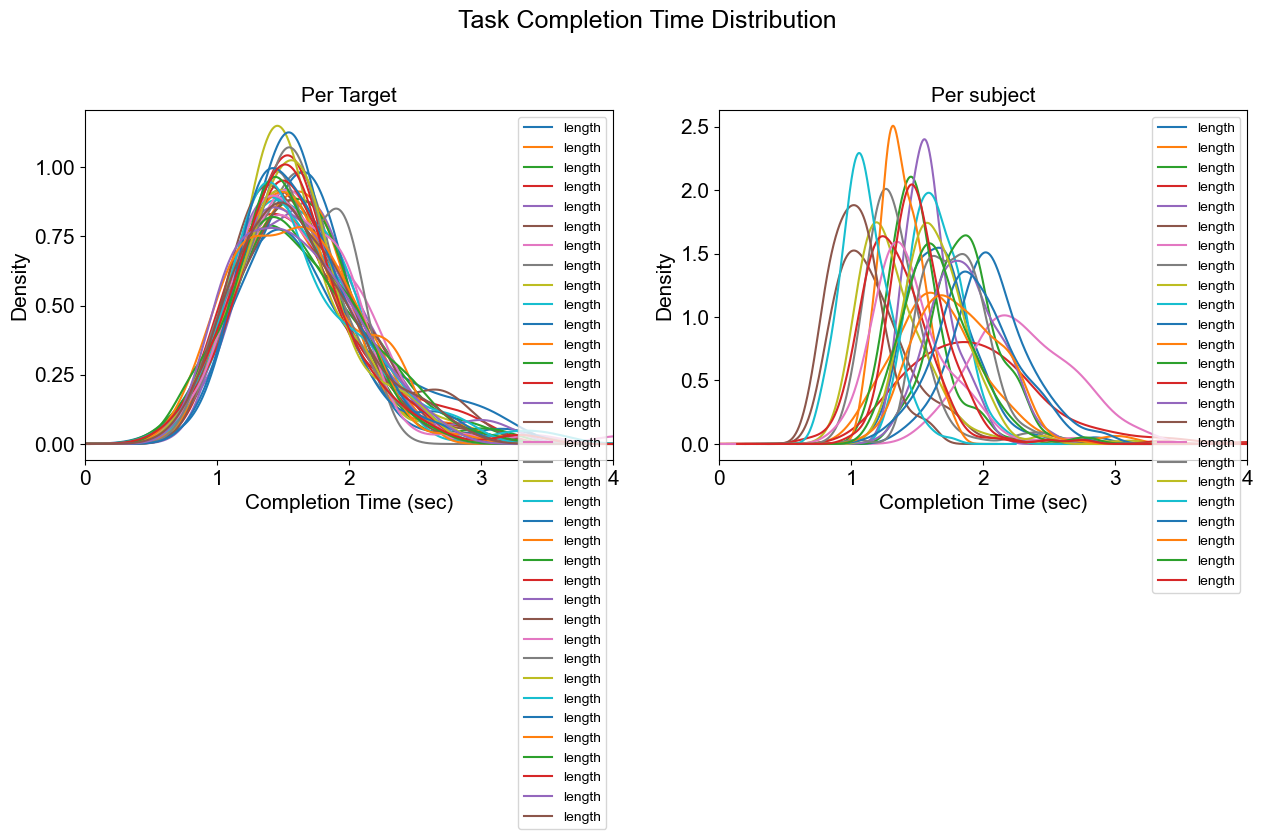

In [2]:

# need ticks to act as grid : https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

def plot_tasktime_distribution(dffile):
    # https://note.nkmk.me/en/python-pandas-multiple-conditions/#select-rows-by-multiple-conditions
    """
    dffile = pd of ['sub_idx','file_idx','length', 'h','v','d']
    
    1. use sub(0-15)
    2. isolate by 36 combinations
    3. find mean avg / std for length
    """
    
    
    # ==== common plot ==============================
    plt.figure(figsize=(15,10))
    plt.suptitle("Task Completion Time Distribution", fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    
    # ==== grid ticks ==============================
    major_ticks = np.arange(0, 5, 20)
    minor_ticks = np.arange(0, 5, 5)
    
    
    # ===== plot by combination =====================
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("Per Target", fontsize=15)
    ax1.set_xlabel('Completion Time (sec)', fontsize=15)
    ax1.set_ylabel('density', fontsize=15)
    ax1.locator_params(nbins=5, axis='x') #xtick density
    ax1.locator_params(nbins=6, axis='y') #xtick density
    ax1.set_xlim(0, 4)
    df = dffile.loc[ dffile['sub_idx']<16]
    df_combination = pd.DataFrame()
    for cIdx in range(36):
        v1, v2, v3, v4 = cIdx, 36+cIdx, 72+cIdx, 108+cIdx
        df_comb = df.loc[ (df['file_idx'] == v1) | (df['file_idx'] ==v2) | (df['file_idx'] == v3) | (df['file_idx'] == v4)]
        df_comb = df_comb.loc[df_comb['length'] > -1].reset_index(drop=True)
        col_name = 'c' + str(cIdx)
        df_comb_length = df_comb['length']/120
        # print(df_comb_length.shape[0], "//", round(df_comb_length.mean(),2), "/", round(df_comb_length.min(),2), "/", round(df_comb_length.max(),2), "/", round(df_comb_length.std(),2))
        ax = df_comb_length.plot.kde()

    
    
    # ===== plot by subject =========================
    ax2 = plt.subplot(2, 2, 2)    
    ax2.set_title("Per subject", fontsize=15)
    ax2.set_xlabel('Completion Time (sec)', fontsize=15)
    ax2.set_ylabel('density', fontsize=15)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    ax2.locator_params(nbins=6, axis='y') #xtick density
    ax2.set_xlim(0, 4)
    
    df = dffile       
    for sIdx in range(24):
        df_sub = df.loc[ (df['sub_idx'] == sIdx) ]
        df_sub = df_sub.loc[df_sub['length'] > -1].reset_index(drop=True)
        df_sub_length = df_sub['length']/120
        # print(sIdx, "//", round(df_sub_length.mean(),2), "/", round(df_sub_length.min(),2), "/", round(df_sub_length.max(),2), "/", round(df_sub_length.std(),2))            
        ax = df_sub_length.plot.kde()
        
    ax1.legend()
    ax2.legend()
    
matplotlib.rcParams['font.family'] = "Arial"    
plot_tasktime_distribution(dffile)        

## 2. Velocity Chart SUM(ABS(all v18 elements))
- will not do plotting. Just writing here

## 3. 

In [10]:
tips = sns.load_dataset("tips")
print(tips.head)

<bound method NDFrame.head of      total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]>
